# **Fantasy Sports League Optimization**

## **Project Description**
This project focuses on optimizing team assignments in a fantasy sports league while ensuring a balanced distribution of talent and adherence to salary constraints. Given a dataset of players with attributes such as skill rating, cost, and position, we aim to assign them to five teams while following strict constraints and achieving a balanced league.

## **Constraints**
- Each team must consist of:
  - 1 Goalkeeper (GK)  
  - 2 Defenders (DEF)  
  - 2 Midfielders (MID)  
  - 2 Forwards (FWD)  
- Each player is assigned to exactly one team.  
- No team may exceed a total budget of **750 million €**.  
- The standard deviation of the average skill rating of all teams should be minimized to ensure fairness.  

## **Objective**
To generate a valid league configuration that follows all constraints and ensures that teams have a similar overall skill level, measured by the standard deviation of their average skill ratings.

## **Group Members**

### **Group X**

| Name                  | Student Number  |
|-----------------------|----------------|
| Philippe Dutranoit   | 20240518        |
| Josua Wehr        | 202040501 |
| Benedikt Ruggaber | 202040500 |
| Daan Van Holten  | 20240681 |

# Context

In this notebook, we run the final genetic algorithm using the selected configuration.

- First, we execute every available combination of mutation, selection, and crossover operators multiple times. For each configuration, we compute the average of the best fitness scores obtained over many runs.
- We then compare these averages to determine which configuration produces the lowest (best) fitness value.
- Based on our tests, we selected the configuration with the lowest average best fitness—namely, the Roulette Wheel Scramble Position-based variant—for the final run.

# Imports and Pre-Sets

In [13]:
# import relavant libraries
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from itertools import product

# import all custom classes
from CrossoverMethods import CrossoverMethods
from League import League
from GeneticAlgorithm import (
    GeneticAlgorithm_tournament_swap_team,
    GeneticAlgorithm_tournament_swap_positionbased,
    GeneticAlgorithm_tournament_positionshuffle_team,
    GeneticAlgorithm_tournament_positionshuffle_positionbased,
    GeneticAlgorithm_tournament_scramble_team,
    GeneticAlgorithm_tournament_scramble_positionbased,
    GeneticAlgorithm_roulette_wheel_swap_team,
    GeneticAlgorithm_roulette_wheel_swap_positionbased,
    GeneticAlgorithm_roulette_wheel_positionshuffle_team,
    GeneticAlgorithm_roulette_wheel_positionshuffle_positionbased,
    GeneticAlgorithm_roulette_wheel_scramble_team,
    GeneticAlgorithm_roulette_wheel_scramble_positionbased
)
from MutationMethods import MutationMethods
from Player import Player
from SelectionMethods import SelectionMethods
from SolutionAnalyzer import SolutionAnalyzer
from Team import Team

In [14]:
from GeneticAlgorithm import *
import inspect

# Print all available classes from GeneticAlgorithm
ga_classes = [name for name, obj in globals().items() 
              if name.startswith('GeneticAlgorithm_') and inspect.isclass(obj)]
print(ga_classes)

['GeneticAlgorithm_tournament_swap_team', 'GeneticAlgorithm_tournament_swap_positionbased', 'GeneticAlgorithm_tournament_positionshuffle_team', 'GeneticAlgorithm_tournament_positionshuffle_positionbased', 'GeneticAlgorithm_tournament_scramble_team', 'GeneticAlgorithm_tournament_scramble_positionbased', 'GeneticAlgorithm_roulette_wheel_swap_team', 'GeneticAlgorithm_roulette_wheel_swap_positionbased', 'GeneticAlgorithm_roulette_wheel_positionshuffle_team', 'GeneticAlgorithm_roulette_wheel_positionshuffle_positionbased', 'GeneticAlgorithm_roulette_wheel_scramble_team', 'GeneticAlgorithm_roulette_wheel_scramble_positionbased']


In [15]:
# set up random seed for reproducibility
random.seed(42)

NUM_TEAMS = 5
PLAYERS_PER_TEAM = 7
BUDGET_LIMIT = 750

In [16]:
df = pd.read_csv('../Data/players(in).csv')


# Apply Tests

In [17]:
# Create player objects
players = []
if df is not None:
    for i, row in df.iterrows():
        player = Player(
            id=i,
            name=row['Name'],
            position=row['Position'],
            skill=row['Skill'],
            salary=row['Salary (€M)']
        )
        players.append(player)

    # Count players by position
    positions = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    for player in players:
        positions[player.position] += 1
    
    print(f"Players by position: {positions}")
    required = {'GK': NUM_TEAMS, 'DEF': NUM_TEAMS*2, 'MID': NUM_TEAMS*2, 'FWD': NUM_TEAMS*2}
    
    # Check if we have enough players
    enough_players = True
    for pos, count in positions.items():
        if count < required[pos]:
            print(f"Not enough {pos} players! Need {required[pos]}, have {count}")
            enough_players = False
    
    if not enough_players:
        print("Warning: Not enough players for all positions!")



Players by position: {'GK': 5, 'DEF': 10, 'MID': 10, 'FWD': 10}


# Algorithm comparison 

Here, we run every combination of selection, crossover, and mutation operators to compare their performance. By averaging the best fitness across multiple runs, we can identify the most effective configuration and use it for our final prediction.

In [18]:
# Step 1: Define the components of the algorithm variants
# These represent all possible values for selection, mutation, and crossover strategies
selection_methods = ['tournament', 'roulette_wheel']
mutation_strategies = ['swap', 'positionshuffle', 'scramble']
crossover_strategies = ['team', 'positionbased']

# Step 2: Define a function to dynamically retrieve the GeneticAlgorithm class
# based on the naming convention, e.g., 'GeneticAlgorithm_tournament_scramble_team'
def get_algorithm_class(selection, mutation, crossover):
    class_name = f"GeneticAlgorithm_{selection}_{mutation}_{crossover}"
    return globals().get(class_name)  # Retrieves the class object from the global namespace

# Step 3: Prepare a list to store the results from each configuration
results = []

# Step 4: Iterate over all combinations of the algorithm components
for selection, mutation, crossover in product(selection_methods, mutation_strategies, crossover_strategies):
    ga_class = get_algorithm_class(selection, mutation, crossover)

    # Step 5: Check if the class actually exists before running
    if ga_class is not None:
        print(f"Running: {ga_class.__name__}")

        # Step 6: Run the genetic algorithm with the current configuration
        # compute_avg_best_fitness returns the average best-fitness per generation
        df = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=ga_class)

        # Step 7: Add metadata columns to keep track of the configuration used
        df['Selection'] = selection
        df['Mutation'] = mutation
        df['Crossover'] = crossover

        # Step 8: Append the result to the results list
        results.append(df)
    else:
        print(f"Class not found: {selection}, {mutation}, {crossover}")

# Step 9: Concatenate all result DataFrames into a single DataFrame
# This makes it easier to analyze and compare performance across configurations
final_df = pd.concat(results, ignore_index=True)


Running: GeneticAlgorithm_tournament_swap_team
Starting genetic algorithm...
Initializing population...
Initial best fitness: 0.5222
Generation 0: Best fitness = 0.3659 (Time: 0.01s)
Generation 10: Best fitness = 0.3182 (Time: 0.07s)
Generation 20: Best fitness = 0.1666 (Time: 0.10s)
Generation 30: Best fitness = 0.1069 (Time: 0.13s)
Generation 40: Best fitness = 0.0571 (Time: 0.16s)
Generation 50: Best fitness = 0.0571 (Time: 0.19s)
Generation 60: Best fitness = 0.0571 (Time: 0.22s)
Generation 70: Best fitness = 0.0571 (Time: 0.25s)
Generation 80: Best fitness = 0.0571 (Time: 0.28s)
Generation 90: Best fitness = 0.0571 (Time: 0.31s)
Generation 99: Best fitness = 0.0571 (Time: 0.33s)
Evolution completed in 0.33 seconds
Final best fitness: 0.0571
Starting genetic algorithm...
Initializing population...
Initial best fitness: 0.1895
Generation 0: Best fitness = 0.1895 (Time: 0.00s)
Generation 10: Best fitness = 0.1895 (Time: 0.03s)
Generation 20: Best fitness = 0.1895 (Time: 0.06s)
Genera

In [19]:
# def compute_avg_best_fitness(players, n_runs=1000, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_tournament_swap_team):
#     """Compute the avg best-fitness per generation over n_runs of the given GA class."""
#     all_histories = np.zeros((n_runs, generations + 1))
#     for run in range(n_runs):
#         ga = GeneticAlgorithm(players, pop_size=pop_size, generations=generations)
#         _, history = ga.run()
#         all_histories[run, :] = history
#     avg_history = all_histories.mean(axis=0)
#     return pd.DataFrame({
#         'Generation': np.arange(generations + 1),
#         'AvgBestFitness': avg_history
#     })

# df_tour_swap_team = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_tournament_swap_team)
# df_tour_swap_positionbased = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_tournament_swap_positionbased)
# df_tour_positionshuffle_team = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_tournament_positionshuffle_team)
# df_tour_positionshuffle_positionbased = compute_avg_best_fitness(players, n_runs=100, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_tournament_positionshuffle_positionbased)
# df_tour_scramble_team = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_tournament_scramble_team)
# df_tour_scramble_positionbased = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_tournament_scramble_positionbased)
# df_roulette_swap_team = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_roulette_wheel_swap_team)
# df_roulette_swap_positionbased = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_roulette_wheel_swap_positionbased)
# df_roulette_positionshuffle_team = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_roulette_wheel_positionshuffle_team)
# df_roulette_positionshuffle_positionbased = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_roulette_wheel_positionshuffle_positionbased)
# df_roulette_scramble_team = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_roulette_wheel_scramble_team)
# df_roulette_scramble_positionbased = compute_avg_best_fitness(players, n_runs=10, pop_size=35, generations=100, GeneticAlgorithm=GeneticAlgorithm_roulette_wheel_scramble_positionbased)

In [20]:
variant_dfs = {
    'Tournament Swap Team': df_tour_swap_team,
    'Tournament Swap Position-based': df_tour_swap_positionbased,
    'Tournament Position Shuffle Team': df_tour_positionshuffle_team,
    'Tournament Position Shuffle Position-based': df_tour_positionshuffle_positionbased,
    'Tournament Scramble Team': df_tour_scramble_team,
    'Tournament Scramble Position-based': df_tour_scramble_positionbased,
    'Roulette Wheel Swap Team': df_roulette_swap_team,
    'Roulette Wheel Swap Position-based': df_roulette_swap_positionbased,
    'Roulette Wheel Position Shuffle Team': df_roulette_positionshuffle_team,
    'Roulette Wheel Position Shuffle Position-based': df_roulette_positionshuffle_positionbased,
    'Roulette Wheel Scramble Team': df_roulette_scramble_team,
    'Roulette Wheel Scramble Position-based': df_roulette_scramble_positionbased
}
dfs = []
for variant_name, df_variant in variant_dfs.items():
    df_temp = df_variant.copy().set_index('Generation')
    df_temp = df_temp.rename(columns={'AvgBestFitness': variant_name})
    dfs.append(df_temp)

merged_df = pd.concat(dfs, axis=1).reset_index()
merged_df

,Generation,Tournament Swap Team,Tournament Swap Position-based,Tournament Position Shuffle Team,Tournament Position Shuffle Position-based,Tournament Scramble Team,Tournament Scramble Position-based,Roulette Wheel Swap Team,Roulette Wheel Swap Position-based,Roulette Wheel Position Shuffle Team,Roulette Wheel Position Shuffle Position-based,Roulette Wheel Scramble Team,Roulette Wheel Scramble Position-based
0,0,0.375702,0.419044,0.464767,0.447495,0.373478,0.403841,0.382850,0.455279,0.474299,0.363814,0.466038,0.463111
1,1,0.333848,0.346443,0.391771,0.345486,0.297406,0.367195,0.348818,0.384118,0.379712,0.331832,0.395389,0.358421
2,2,0.284407,0.308457,0.362987,0.302575,0.280226,0.265683,0.295920,0.330690,0.352319,0.278968,0.380671,0.358421
3,3,0.275189,0.279329,0.330086,0.270059,0.254992,0.207717,0.284516,0.268520,0.349485,0.272885,0.299386,0.308948
4,4,0.254064,0.246868,0.320186,0.243808,0.232010,0.204594,0.275654,0.246136,0.338184,0.271845,0.297476,0.251303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,0.093514,0.062119,0.132070,0.135724,0.125166,0.087993,0.057143,0.062119,0.144023,0.140702,0.106228,0.067095
97,97,0.093514,0.062119,0.132070,0.135724,0.125166,0.087993,0.057143,0.062119,0.144023,0.140702,0.106228,0.067095
98,98,0.093514,0.057143,0.132070,0.134898,0.125166,0.087993,0.057143,0.062119,0.144023,0.140702,0.106228,0.067095
99,99,0.093514,0.057143,0.132070,0.134301,0.122503,0.087993,0.057143,0.062119,0.144023,0.140702,0.106228,0.067095


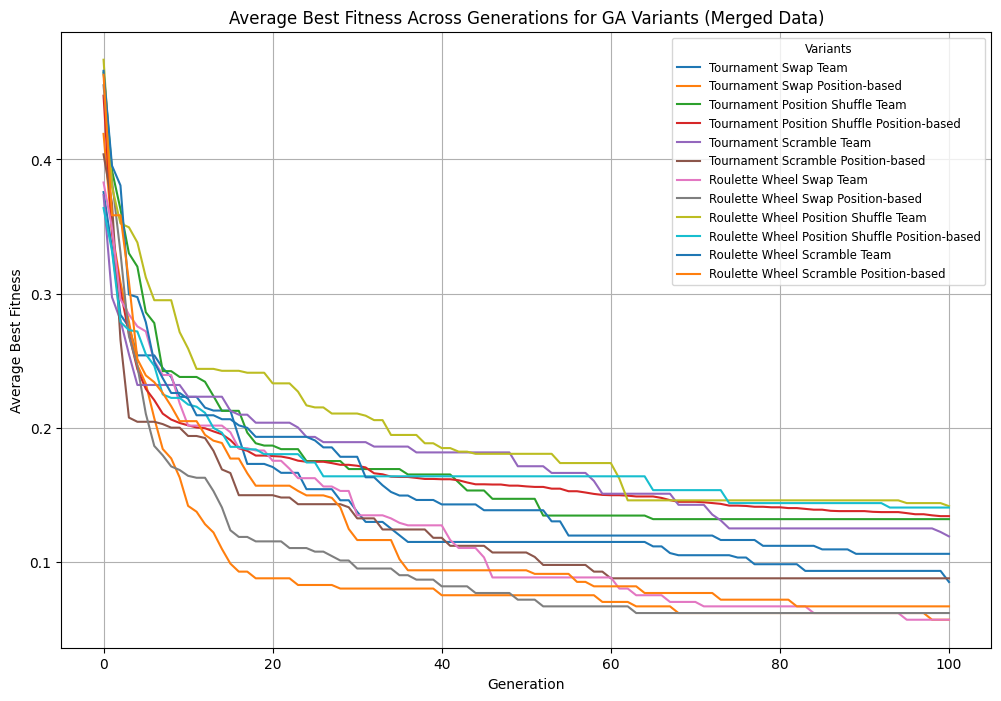

In [21]:
ax = merged_df.set_index('Generation').plot(grid=True)
ax.set_title("Average Best Fitness Across Generations for GA Variants (Merged Data)")
ax.set_xlabel("Generation")
ax.set_ylabel("Average Best Fitness")
plt.legend(title="Variants", loc='upper right')
plt.gcf().set_size_inches(12, 8)
plt.legend(title="Variants", loc='upper right', fontsize='small', title_fontsize='small')
plt.show()

In [22]:
#%pip install scipy.stats

In [23]:
import numpy as np
from scipy.stats import ranksums

metrics = merged_df.columns.difference(['Generation'])
n = len(metrics)

for i in range(n):
    col_i = metrics[i]
    data_i = merged_df[col_i].values
    
    for j in range(i+1, n):
        col_j = metrics[j]
        data_j = merged_df[col_j].values
        
        # now test column i vs. column j
        stat, p = ranksums(data_i, data_j)
        print(f"{col_i} vs {col_j}: stat = {stat:.3f},  p = {p:.3e}")

Roulette Wheel Position Shuffle Position-based vs Roulette Wheel Position Shuffle Team: stat = -3.270,  p = 1.075e-03
Roulette Wheel Position Shuffle Position-based vs Roulette Wheel Scramble Position-based: stat = 7.606,  p = 2.834e-14
Roulette Wheel Position Shuffle Position-based vs Roulette Wheel Scramble Team: stat = 4.864,  p = 1.151e-06
Roulette Wheel Position Shuffle Position-based vs Roulette Wheel Swap Position-based: stat = 9.693,  p = 3.236e-22
Roulette Wheel Position Shuffle Position-based vs Roulette Wheel Swap Team: stat = 6.766,  p = 1.328e-11
Roulette Wheel Position Shuffle Position-based vs Tournament Position Shuffle Position-based: stat = 2.286,  p = 2.227e-02
Roulette Wheel Position Shuffle Position-based vs Tournament Position Shuffle Team: stat = 2.993,  p = 2.759e-03
Roulette Wheel Position Shuffle Position-based vs Tournament Scramble Position-based: stat = 8.309,  p = 9.682e-17
Roulette Wheel Position Shuffle Position-based vs Tournament Scramble Team: stat = 

# Final Prediction

In [24]:
Best_ga = GeneticAlgorithm_roulette_wheel_scramble_positionbased(players, pop_size=35,generations=100)
best_league, fitness_history = Best_ga.run()

# 2) Analyze in console
SolutionAnalyzer.analyze_solution(best_league)

# 3) Export to CSV
SolutionAnalyzer.export_solution_to_csv(
    best_league,
    'best_solution.csv'
)


Starting genetic algorithm...
Initializing population...
Initial best fitness: 0.1666
Generation 0: Best fitness = 0.1666 (Time: 0.03s)
Generation 10: Best fitness = 0.1069 (Time: 0.30s)
Generation 20: Best fitness = 0.1069 (Time: 0.57s)
Generation 30: Best fitness = 0.0571 (Time: 0.85s)
Generation 40: Best fitness = 0.0571 (Time: 1.12s)
Generation 50: Best fitness = 0.0571 (Time: 1.40s)
Generation 60: Best fitness = 0.0571 (Time: 1.68s)
Generation 70: Best fitness = 0.0571 (Time: 1.95s)
Generation 80: Best fitness = 0.0571 (Time: 2.23s)
Generation 90: Best fitness = 0.0571 (Time: 2.50s)
Generation 99: Best fitness = 0.0571 (Time: 2.75s)
Evolution completed in 2.75 seconds
Final best fitness: 0.0571

FANTASY LEAGUE SOLUTION ANALYSIS

League Standard Deviation: 0.0571
League Valid: True

TEAM DETAILS:

Team 1:
  Average Skill: 86.43
  Total Salary: 669M€ (Limit: 750M€)
  Valid Formation: True
  Within Budget: True
  Players:
    GK:
      - Jordan Smith (Skill: 88, Salary: 100M€)
    DE

TODO:

- SolutionAnalyzer kick out or atleast code it else way (Phil)
- Compare the diffrent algorithms in a chart (Phil)
- comments (Josh)



Report:
- Check Search Space (Daan)
- finsh up report ()
- 
